<a href="https://colab.research.google.com/github/RX-93nu/Bert-VITS2/blob/master/2011outBreak_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
library(readxl)
library(ggplot2)
library(dplyr)
library(lubridate)
library(tidyr)
system("apt install r-cran-moments")
library(moments)
system("pip install gdown==4.6.0")
system("gdown --id 1e6jU3M8orWdjm-EP_BzqSMg0w2HGJUdB")
# https://docs.google.com/spreadsheets/d/1e6jU3M8orWdjm-EP_BzqSMg0w2HGJUdB/edit?usp=sharing&ouid=101312767072026756611&rtpof=true&sd=true
# https://drive.google.com/file/d/1vGFuEfsTFP8jt4ueiu_EQ1WIM35hLpqI/view?usp=sharing
system("gdown --id 1vGFuEfsTFP8jt4ueiu_EQ1WIM35hLpqI")
Sys.setenv(MAKEFLAGS = paste0("-j",parallel::detectCores()))
system("add-apt-repository ppa:marutter/rrutter4.0")
system("add-apt-repository ppa:c2d4u.team/c2d4u4.0+")
system("apt update")
system("apt install r-cran-rstan")
library(rstan)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
system("apt install r-cran-bayesplot")
library(bayesplot)
system("apt install r-cran-rstanarm")
library("rstanarm")

In [33]:
library(readr)
df_collect = read_csv("082712B.csv",
    col_types = cols(Date = col_date(format = "%Y/%m/%d"),
        Count = col_number()))

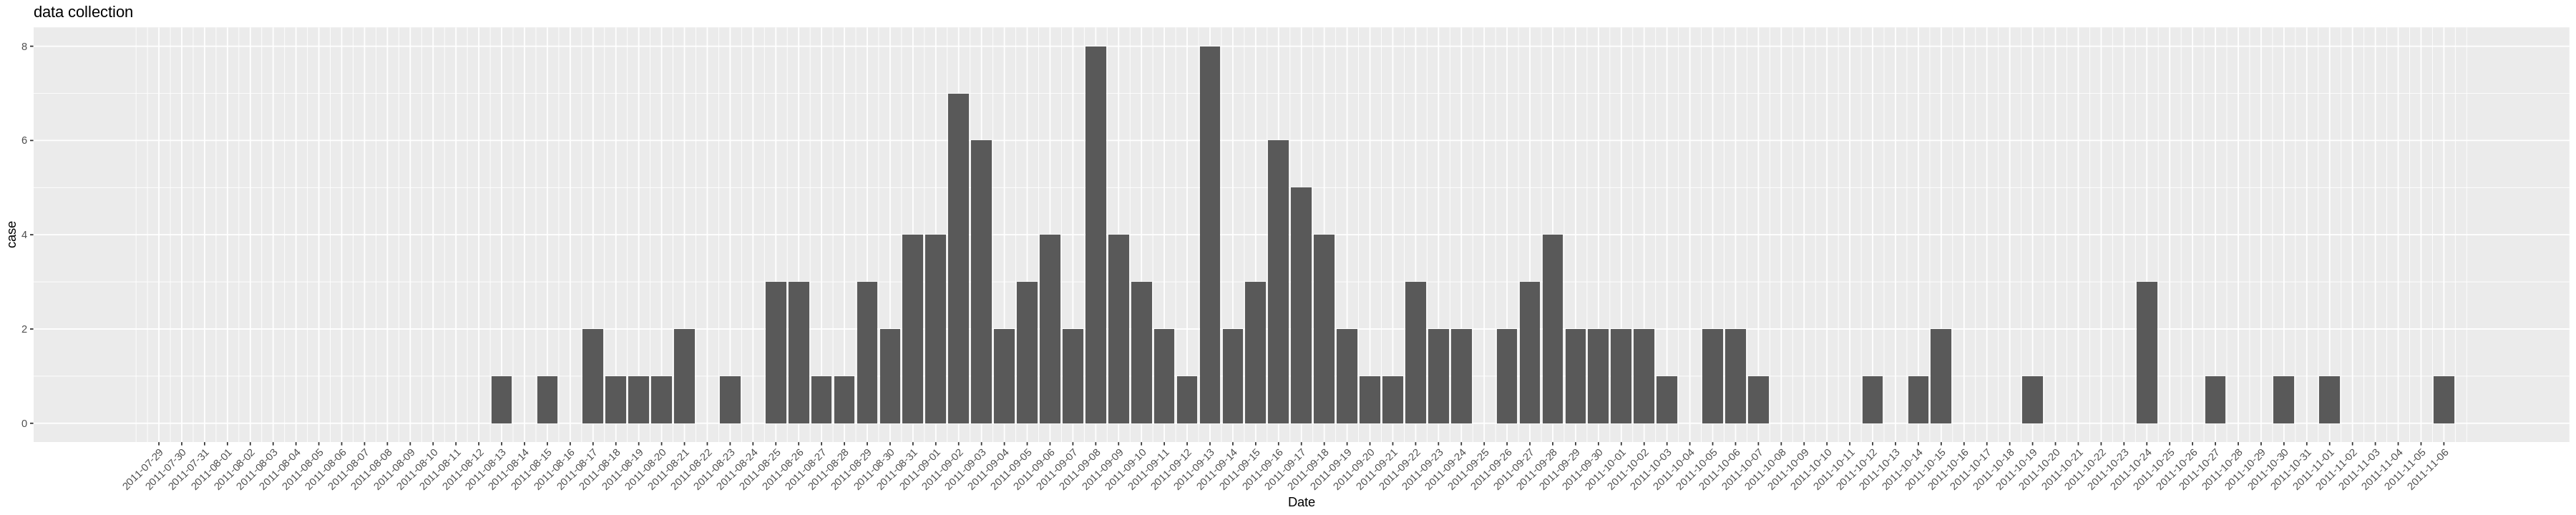

In [34]:
options(repr.plot.width=30, repr.plot.height=6)
df_collect |> ggplot(aes(x = Date, y = Count)) +
  geom_col() +
  scale_x_continuous(breaks = df_collect$Date, labels = df_collect$Date) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab(df_collect$Date) +
  labs(title = "data collection",
       x = "Date",
       y = "case")

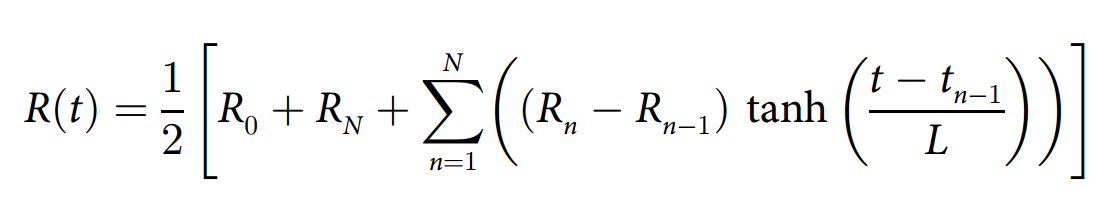

In [56]:
stan_code = 'data {
  int<lower=0> N;  // number of days
  real L;          // characteristic transition time
  array[N] int<lower=0> incidence;
  real<lower=0> R0; // initial reproduction number
  real<lower=0> RN; // final reproduction number
}

parameters {
  real<lower=0> R1;
  real t0;
  real t1;
  real<lower=0> base_incidence;
}

transformed parameters {
  vector[N] R;
  for (t in 1:N) {
    R[t] = 0.5 * (R0 + RN + (R1 - R0) * tanh((t - t0) / L) + (RN - R1) * tanh((t - t1) / L));
  }
}

model {
  R1 ~ normal(N, N);
  t0 ~ normal(N, N);
  t1 ~ normal(N, N);
  base_incidence ~ lognormal(log(mean(incidence)), 1);

  for (n in 1:N) {
    incidence[n] ~ poisson(base_incidence * R[n]);
  }
}

generated quantities {
  vector[N] R_pred;
  vector[N] case_pred;

  for (n in 1:N) {
    R_pred[n] = R[n];
    case_pred[n] = poisson_rng(base_incidence * R[n]);
  }
}

'

stan_data = list(
    N = nrow(df_collect),
    L = 3,
    incidence = df_collect$Count,
    R0 = 0.1,
    RN = 2
)

mod = stan_model(model_code = stan_code, verbose = TRUE)
fit = sampling(mod, data = stan_data, chains = 4, iter = 10000)


TRANSLATING MODEL '' FROM Stan CODE TO C++ CODE NOW.


recompiling to avoid crashing R session



OS: x86_64, linux-gnu; rstan: 2.32.6; Rcpp: 1.0.13; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/usr/lib/R/site-library/rstan/lib//libStanServices.a' -L'/usr/lib/R/site-library/StanHeaders/lib/' -lStanHeaders -L'/usr/lib/R/site-library/RcppParallel/lib/' -ltbb 
PKG_CPPFLAGS =   -I"/usr/lib/R/site-library/Rcpp/include/"  -I"/usr/lib/R/site-library/RcppEigen/include/"  -I"/usr/lib/R/site-library/RcppEigen/include/unsupported"  -I"/usr/lib/R/site-library/BH/include" -I"/usr/lib/R/site-library/StanHeaders/include/src/"  -I"/usr/lib/R/site-library/StanHeaders/include/"  -I"/usr/lib/R/site-library/RcppParallel/include/"  -I"/usr/lib/R/site-library/rstan/include" -DEIGEN_NO_DEBUG  -DBOOST_DISABLE_ASSERTS  -DBOOST_PENDING_INTEGER_LOG2_HPP  -DSTAN_THREADS  -DUSE_STANC3 -DSTRICT_R_HEADERS  -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION  -D_HAS_AUTO_PTR_ETC=0  -include '/usr/lib/R/site-library/StanHeaders/include/stan/math/prim/fun/Eigen.hpp'  -D_REENTRANT -DRCPP_PARALLEL_USE_TBB=1 


In [57]:
fit

Inference for Stan model: anon_model.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
R1              13.37    0.05 4.06   7.59  10.51  12.66  15.39  23.35  7331
t0              21.15    0.01 1.49  18.25  20.15  21.13  22.12  24.12 13061
t1              66.63    0.02 2.09  62.51  65.27  66.66  68.04  70.58 11497
base_incidence   0.23    0.00 0.06   0.13   0.19   0.23   0.27   0.37  7706
R[1]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[2]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[3]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[4]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[5]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[6]             0.10    0.00 0.00   0.10   0.10   0.10   0.10   0.10 10324
R[7]  

In [58]:
df_res = extract(fit)

In [59]:
case_mean = apply(df_res$case_pred, 2, mean)
case_ci = apply(df_res$case_pred, 2, quantile, probs = c(0.025, 0.975))

In [60]:
case_data = data.frame(
    x = 1:length(case_mean),
    mean = case_mean,
    lower = case_ci[1,],
    upper = case_ci[2,]
)

In [61]:
case_data

x,mean,lower,upper
<int>,<dbl>,<dbl>,<dbl>
1,0.02260,0,0.000
2,0.02250,0,0.000
3,0.02320,0,0.000
4,0.02360,0,0.000
5,0.02485,0,0.000
6,0.02245,0,0.000
7,0.02395,0,0.000
8,0.02545,0,0.025
9,0.02600,0,1.000


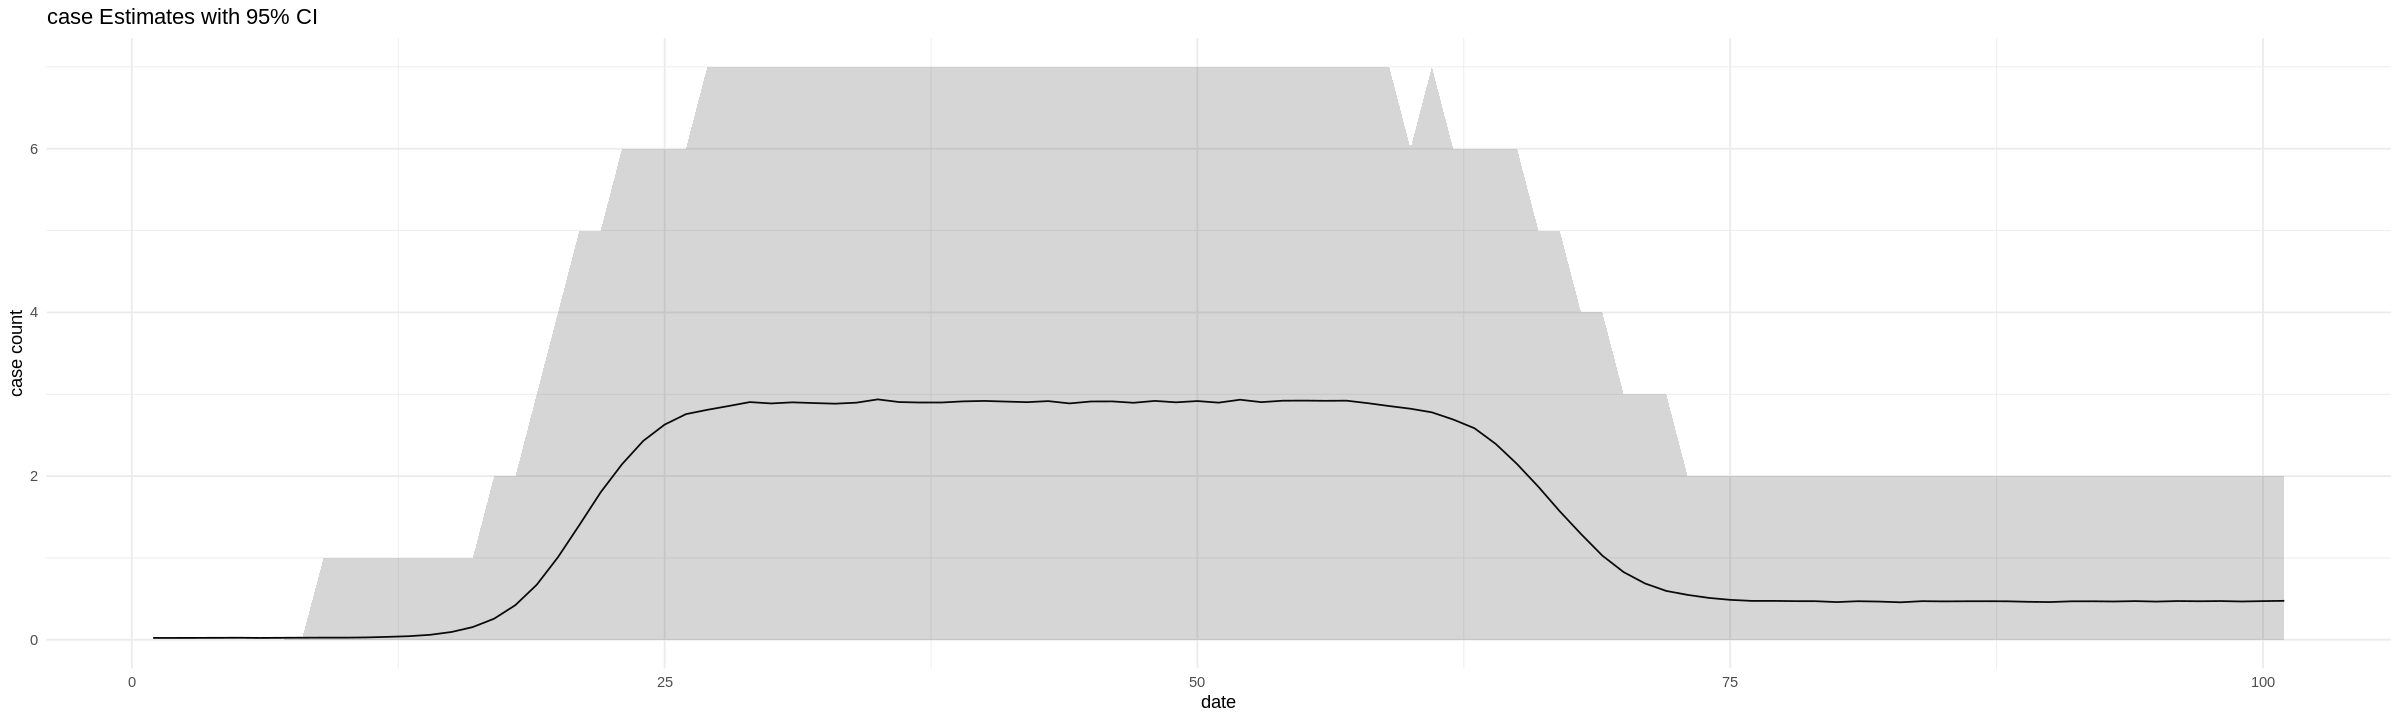

In [62]:
ggplot(case_data, aes(x = x, y = mean)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
  theme_minimal() +
  labs(title = "case Estimates with 95% CI",
       x = "date",
       y = "case count")